In [161]:
# imports 

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START,END,add_messages, MessagesState
from langgraph.graph.state import CompiledGraph
from langgraph.graph.message import add_messages
from typing_extensions import Annotated
from typing import TypedDict
import os

api_key = os.getenv("GEMINI_API_KEY")

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=api_key)

In [162]:
llm.invoke("Hi?")

AIMessage(content='Hi there! How can I help you today?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-710edd1a-b6d3-457e-b03c-7c39da95907a-0', usage_metadata={'input_tokens': 3, 'output_tokens': 11, 'total_tokens': 14, 'input_token_details': {'cache_read': 0}})

In [164]:
# Now Start to creating the whole system but first create some db

departments = [{
    "name": "Computer Science",
    "location": "New York",
    "head": "Dr. Smith",
    "phone": "123-456-7890",
    "email": "i2O1k@example.com",
    "website": "https://example.com/computer-science",
    "id": "01",
    },
    {
    "name": "Mathematics",
    "location": "San Francisco",
    "head": "Dr. Johnson",
    "phone": "987-654-3210",
    "email": "2m9w9@example.com",
    "website": "https://example.com/mathematics",
    "id": "02",
    },
    {
    "name": "Physics",
    "location": "London",
    "head": "Dr. Brown",
    "phone": "555-555-5555",
    "email": "f7o8o@example.com",
    "website": "https://example.com/physics",
    "id": "03",
    }   
]

teachers = [
    {
    "name": "Dr. Mike",
    "department": "Computer Science",
    "department_id": "01",
    "email": "i2O1k@example.com",
    "phone": "123-456-7890",
    "tid": "c1",
    },
    {
    "name": "Dr. Andrew",
    "department": "Mathematics",
    "department_id": "02",
    "email": "2m9w9@example.com",
    "phone": "987-654-3210",
    "tid": "m02",
    },
    {
    "name": "Dr. Jognson",
    "department": "Physics",
    "department_id": "03",
    "email": "f7o8o@example.com",
    "phone": "555-555-5555",
    "tid": "p03",
    }
]

courses = [
    {
    "name": "Introduction to Computer Science",
    "teacher": "Dr. Mike",
    "teacher_id": "c1",
    "department": "Computer Science",
    "department_id": "01",
    "id": "01",
    },
    {
    "name": "Calculus 1",
    "teacher": "Dr. Andrew",
    "teacher_id": "m02",
    "department": "Mathematics",
    "department_id": "02",
    "id": "02",
    },
    {
    "name": "Mechanics",
    "teacher": "Dr. Jognson",
    "teacher_id": "p03",
    "department": "Physics",
    "department_id": "03",
    "id": "03",
    }
]


students_info = []

def call_student():
    while True:
        user_input = input("Enter a command: ")
        if user_input == "exit":
            break
        student_name = input("Enter your name: ")
        studetent_id = input("Enter your student id: ")
        student_age = int(input("Enter your age: "))

        info = {
            "name": student_name,
            "student_id": studetent_id,
            "age": student_age,
        }

        students_info.append(info)

# call_student()    
    
    
# display(students_info)

In [50]:
call_student()

In [102]:
display(students_info)

[]

In [189]:
# Now Creating some tools so the llm can interact with these tools according to the student input

from langchain_core.tools import tool

@tool
def greeting(name: str)-> str:
    """
        This tool is design to Give the Greet msg of user accoring to this name 
    """ 
    return f"Welcome to Edge of Web3 {name}. Let's go froggy"

@tool
def retrevie_info_of_department():
    """
    This tool is set to retrevie the available data from databases  from 
    department 
    """
    output = "Hey here is the Information of department:\n"
    for data in departments:
        output += str(data) + "\n"
    return output

@tool
def retrevie_info_of_teacher():
    """
    This tool is set to retrevie the available data from databases  from 
     teachers 
     """

    output = "Hey here is the Information of Teachers:...."
    for data in teachers:
        # print(data)
        output += str(data) + "\n"
    return output

@tool
def retrevie_info_of_courses():
    """
    This tool is set to retrevie the available data from databases  from 
     courses 
     """

    output = "Hey here is the Information of Courses:...."
    for data in courses:
        # print(data)
        output += str(data) + "\n"
    
    return output

@tool
def retrevie_student_info():
    """
        This tool is get the student data from student_info db if data is present
        otherwise it send that you are not student

        Args:
        student_id: str
    """


    output = "Here is the data of students:...."

    for student_data in students_info:
        output += student_data
        # if student_data["student_id"] == student_id:
        #     # print(student_data)
        #     output = str(student_data) + "\n" 
        # else:
        #     print("Id not found")
        
    return output

@tool
def new_addmission():
    """
    This tool handle the process of student new admisson

    """
    call_student()



In [190]:
# ok Great Cool Now Its time to build the AI
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode,tools_condition
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image

llm_with_tools = llm.bind_tools([greeting,retrevie_info_of_department,retrevie_info_of_teacher,retrevie_info_of_courses,new_addmission])

class State(MessagesState):
    # messages: list
    pass

def chat_llm(state: State):
    # Get the full message history
    messages = state["messages"]
    
    # Invoke LLM with proper message format
    response = llm_with_tools.invoke(messages)
    
    # Return the updated state
    return {"messages": messages + [response]}

# Now construct the graph

# builder: StateGraph = StateGraph(state_schema=State)
# builder.add_node("chat_llm",chat_llm)
# builder.add_node("tools",ToolNode([greeting,retrevie_info_of_department,retrevie_info_of_teacher,retrevie_info_of_courses,new_addmission]))

# builder.add_edge(START, "chat_llm")
# builder.add_conditional_edges("chat_llm",tools_condition)
# builder.add_edge("tools","chat_llm")

builder = StateGraph(State)
builder.add_node("chat_llm", chat_llm)
builder.add_node("tools", ToolNode([
    greeting,
    retrevie_info_of_department,
    retrevie_info_of_teacher,
    retrevie_info_of_courses,
    new_addmission
]))

builder.set_entry_point("chat_llm")
builder.add_conditional_edges(
    "chat_llm",
    tools_condition,
    {"tools": "tools", END: END}
)
builder.add_edge("tools", "chat_llm")

graph: CompiledGraph = builder.compile()


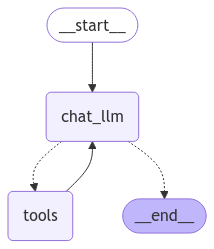

In [192]:

Image(graph.get_graph().draw_mermaid_png())

In [168]:
llm.invoke("Hi")

AIMessage(content='Hi there! How can I help you today?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-b342c63d-492b-4455-99af-883431ee6930-0', usage_metadata={'input_tokens': 2, 'output_tokens': 11, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}})

In [193]:
message = graph.invoke({"messages": [HumanMessage(content="My Name is Ali")]})

# Print the messages
for m in message['messages']:
    m.pretty_print()

================================ Human Message =================================

My Name is Ali
================================== Ai Message ==================================
Tool Calls:
  greeting (e1b6eeea-3ea1-46ab-8c2d-83024d4babc0)
 Call ID: e1b6eeea-3ea1-46ab-8c2d-83024d4babc0
  Args:
    name: Ali
================================= Tool Message =================================
Name: greeting

Welcome to Edge of Web3 Ali. Let's go froggy
================================== Ai Message ==================================

Welcome to Edge of Web3 Ali. Let's go froggy


In [170]:
message = graph.invoke({"messages": [HumanMessage(content="Whats the department data")]})
# Instead of passing the HumanMessage directly,
# pass a dictionary with a text field.
# message = graph.invoke({"messages": [{"text": "I need information of departments"}]})


# Print the messages
for m in message['messages']:
    m.pretty_print()

================================ Human Message =================================

Whats the department data
================================== Ai Message ==================================
Tool Calls:
  retrevie_info_of_department (1231666a-4569-42a6-a3e3-679fcee1dc86)
 Call ID: 1231666a-4569-42a6-a3e3-679fcee1dc86
  Args:
================================= Tool Message =================================
Name: retrevie_info_of_department

Hey here is the Information of department:
{'name': 'Computer Science', 'location': 'New York', 'head': 'Dr. Smith', 'phone': '123-456-7890', 'email': 'i2O1k@example.com', 'website': 'https://example.com/computer-science', 'id': '01'}
{'name': 'Mathematics', 'location': 'San Francisco', 'head': 'Dr. Johnson', 'phone': '987-654-3210', 'email': '2m9w9@example.com', 'website': 'https://example.com/mathematics', 'id': '02'}
{'name': 'Physics', 'location': 'London', 'head': 'Dr. Brown', 'phone': '555-555-5555', 'email': 'f7o8o@example.com', 'website': 'https

In [171]:
message = graph.invoke({"messages": [HumanMessage(content="He I want admission man")]})
# Instead of passing the HumanMessage directly,
# pass a dictionary with a text field.
# message = graph.invoke({"messages": [{"text": "I need information of departments"}]})


# Print the messages
for m in message['messages']:
    m.pretty_print()

================================ Human Message =================================

He I want admission man
================================== Ai Message ==================================
Tool Calls:
  new_addmission (5675c981-473a-463c-ad96-ed5291172cb3)
 Call ID: 5675c981-473a-463c-ad96-ed5291172cb3
  Args:
================================= Tool Message =================================
Name: new_addmission

null
================================== Ai Message ==================================

OK. I have started your admission process.  What information do you need to provide?


In [178]:
message = graph.invoke({"messages": [HumanMessage(content="check it that the name Ali student is in?")]})
# Instead of passing the HumanMessage directly,
# pass a dictionary with a text field.
# message = graph.invoke({"messages": [{"text": "I need information of departments"}]})


# Print the messages
for m in message['messages']:
    m.pretty_print()

================================ Human Message =================================

check it that the name Ali student is in?
================================== Ai Message ==================================

I need more information to answer your question.  The available tools don't allow searching for a student by name.  Is there a student ID or other identifier I can use?


In [176]:
students_info

[{'name': 'ALi', 'student_id': '21', 'age': 24}]

In [183]:
message = graph.invoke({"messages": [HumanMessage(content="Hi I need assissment and my name is Ali")]})
# Instead of passing the HumanMessage directly,
# pass a dictionary with a text field.
# message = graph.invoke({"messages": [{"text": "I need information of departments"}]})


# Print the messages
for m in message['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi I need assissment and my name is Ali
================================== Ai Message ==================================
Tool Calls:
  greeting (7a20d8d7-6638-40e5-8208-1d02d0e42751)
 Call ID: 7a20d8d7-6638-40e5-8208-1d02d0e42751
  Args:
    name: Ali
================================= Tool Message =================================
Name: greeting

Welcome to Edge of Web3 Ali. Let's go froggy
================================== Ai Message ==================================

Welcome to Edge of Web3 Ali. Let's go froggy.  Anything else I can help you with today?


In [184]:
message = graph.invoke({"messages": [HumanMessage(content="is the department of computer sciense is present? Give me the detail of this department please")]})
# Instead of passing the HumanMessage directly,
# pass a dictionary with a text field.
# message = graph.invoke({"messages": [{"text": "I need information of departments"}]})


# Print the messages
for m in message['messages']:
    m.pretty_print()

================================ Human Message =================================

is the department of computer sciense is present? Give me the detail of this department please
================================== Ai Message ==================================
Tool Calls:
  retrevie_info_of_department (100f5a63-9998-4516-b36c-0f2de2773c36)
 Call ID: 100f5a63-9998-4516-b36c-0f2de2773c36
  Args:
================================= Tool Message =================================
Name: retrevie_info_of_department

Hey here is the Information of department:
{'name': 'Computer Science', 'location': 'New York', 'head': 'Dr. Smith', 'phone': '123-456-7890', 'email': 'i2O1k@example.com', 'website': 'https://example.com/computer-science', 'id': '01'}
{'name': 'Mathematics', 'location': 'San Francisco', 'head': 'Dr. Johnson', 'phone': '987-654-3210', 'email': '2m9w9@example.com', 'website': 'https://example.com/mathematics', 'id': '02'}
{'name': 'Physics', 'location': 'London', 'head': 'Dr. Brown', 'ph

In [194]:
message = graph.invoke({"messages": [HumanMessage(content="Hey I want to that what type of Courses in Compputer Sciense Department")]})
# Instead of passing the HumanMessage directly,
# pass a dictionary with a text field.
# message = graph.invoke({"messages": [{"text": "I need information of departments"}]})


# Print the messages
for m in message['messages']:
    m.pretty_print()

================================ Human Message =================================

Hey I want to that what type of Courses in Compputer Sciense Department
================================== Ai Message ==================================
Tool Calls:
  retrevie_info_of_courses (a449cb27-8d9b-4f55-adc4-3d064aad1847)
 Call ID: a449cb27-8d9b-4f55-adc4-3d064aad1847
  Args:
================================= Tool Message =================================
Name: retrevie_info_of_courses

Hey here is the Information of Courses:....{'name': 'Introduction to Computer Science', 'teacher': 'Dr. Mike', 'teacher_id': 'c1', 'department': 'Computer Science', 'department_id': '01', 'id': '01'}
{'name': 'Calculus 1', 'teacher': 'Dr. Andrew', 'teacher_id': 'm02', 'department': 'Mathematics', 'department_id': '02', 'id': '02'}
{'name': 'Mechanics', 'teacher': 'Dr. Jognson', 'teacher_id': 'p03', 'department': 'Physics', 'department_id': '03', 'id': '03'}

================================== Ai Message ==========

In [186]:
message = graph.invoke({"messages": [HumanMessage(content="Ok Now Tell me is there is any student whose name is Ali and Id is 21?")]})
# Instead of passing the HumanMessage directly,
# pass a dictionary with a text field.
# message = graph.invoke({"messages": [{"text": "I need information of departments"}]})


# Print the messages
for m in message['messages']:
    m.pretty_print()

================================ Human Message =================================

Ok Now Tell me is there is any student whose name is Ali and Id is 21?
================================== Ai Message ==================================

I am sorry, I cannot directly access student information to check if a student with the name "Ali" and ID 21 exists.  The available tools do not provide a way to query student data by name and ID.


In [196]:
message = graph.invoke({"messages": [HumanMessage(content="Ok I want addmssion")]})
# Instead of passing the HumanMessage directly,
# pass a dictionary with a text field.
# message = graph.invoke({"messages": [{"text": "I need information of departments"}]})


# Print the messages
for m in message['messages']:
    m.pretty_print()

================================ Human Message =================================

Ok I want addmssion
================================== Ai Message ==================================
Tool Calls:
  new_addmission (bcdc38f6-3f23-4e52-88ca-2b9428445ec6)
 Call ID: bcdc38f6-3f23-4e52-88ca-2b9428445ec6
  Args:
================================= Tool Message =================================
Name: new_addmission

null
================================== Ai Message ==================================

OK. I have started your admission process.  What information do you need from me to continue?


In [197]:
message = graph.invoke({"messages": [HumanMessage(content="Now Get the data of student")]})
# Instead of passing the HumanMessage directly,
# pass a dictionary with a text field.
# message = graph.invoke({"messages": [{"text": "I need information of departments"}]})


# Print the messages
for m in message['messages']:
    m.pretty_print()

================================ Human Message =================================

Now Get the data of student
================================== Ai Message ==================================

The available tools don't directly provide student data.  There's no function to retrieve student information.  To get student data, new APIs would need to be added.
